In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## 응답 별 features & reward score

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from transformers import (
    AutoModelForSequenceClassification,
    AutoModelForCausalLM, # SFT 모델을 이용한 응답 생성을 위해 추가
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from peft import PeftModel

# ====================================================================
# 1. 설정: 학습 때와 동일한 설정을 사용해야 합니다.
# ====================================================================

# 1. 불러올 기본 모델 ID (학습 때 사용한 모델)
base_model_id = "unsloth/llama-3.2-1b-instruct-bnb-4bit"

# 2. 저장된 LoRA 어댑터가 있는 폴더 경로
#    학습 스크립트의 'output_dir'에 지정된 경로 아래 'final_reward_adapters' 또는 마지막 체크포인트
adapter_path = "../final_reward_adapters_length_bias" # trainer.save_model()로 저장한 경로

# 응답 생성을 위한 SFT
sft_adapter_path = "../final_sft_adapters"

/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ====================================================================
# 2. 보상 모델 및 토크나이저 로딩
# ====================================================================

print("💾 기본 모델과 토크나이저를 로드합니다...")

# 4비트 양자화 설정 (학습 때와 동일)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# 기본 모델 로드 (주의: 아직 어댑터가 적용되지 않은 순수 기본 모델)
base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    num_labels=1, # 학습 때와 동일하게 num_labels=1 설정
)

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
# ==================== 여기부터 수정 코드를 추가합니다 ====================
print("🔄 문제가 되는 'score' 레이어를 교체하고 올바른 디바이스로 이동합니다...")

in_features = base_model.score.in_features
new_score_layer = torch.nn.Linear(
    in_features,
    1,
    bias=False,
    dtype=torch.float16 # 모델의 나머지 부분과 맞추기 위해 float16으로 직접 지정
)

# 새로 만든 레이어를 모델의 나머지 부분과 동일한 디바이스(GPU)로 이동시킵니다.
base_model.score = new_score_layer.to(base_model.device)

print("✅ 'score' 레이어 교체 및 디바이스 이동 완료!")
# ======================================================================

# --- LoRA 어댑터 적용 ---
print(f"✅ 기본 모델에 '{adapter_path}'의 어댑터를 적용합니다...")

# PeftModel.from_pretrained를 사용하여 기본 모델에 저장된 어댑터 가중치를 합칩니다.
# 이것이 최종적으로 우리가 사용할 보상 모델입니다.
reward_model = PeftModel.from_pretrained(base_model, adapter_path)

# 모델을 평가 모드로 설정합니다. (Dropout 등 비활성화)
reward_model.eval()

print("🎉 보상 모델 로딩 및 테스트 준비 완료!")

💾 기본 모델과 토크나이저를 로드합니다...


/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at unsloth/llama-3.2-1b-instruct-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 문제가 되는 'score' 레이어를 교체하고 올바른 디바이스로 이동합니다...
✅ 'score' 레이어 교체 및 디바이스 이동 완료!
✅ 기본 모델에 '../final_reward_adapters_length_bias'의 어댑터를 적용합니다...
🎉 보상 모델 로딩 및 테스트 준비 완료!


In [4]:
# ====================================================================
# 3. 응답 생성을 위한 SFT 모델 로드 (수정된 부분)
# ====================================================================
print("\n🔄 분석용 응답 생성을 위해 SFT 모델을 로드합니다...")
# 1. 기본 CausalLM 모델 로드
sft_base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
)
# 토크나이저는 rm_tokenizer와 동일하므로 별도 로드 필요 없음

# 2. SFT 어댑터 결합
generator_model = PeftModel.from_pretrained(sft_base_model, sft_adapter_path)
generator_model.eval()
print("🎉 SFT 모델 로딩 완료!")


🔄 분석용 응답 생성을 위해 SFT 모델을 로드합니다...


/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/transformers/quantizers/auto.py:222: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


🎉 SFT 모델 로딩 완료!


In [5]:
# ====================================================================
# 4. SFT 모델을 이용한 짧은 응답 / 긴 응답 생성 (수정된 부분)
# ====================================================================
print("\n🔄 SFT 모델을 이용해 응답 150개를 생성합니다...")

# max_new_tokens를 각 호출 시 지정하기 위해 파이프라인 생성 시에는 제거합니다.
pipe = pipeline("text-generation", model=generator_model, tokenizer=tokenizer)

analysis_prompt = "Explain the concept of 'large language model' to a 5-year-old."
num_samples_each_type = 50 # 각 종류별로 50개씩, 총 150개 생성
# 그냥 나누지 말고 생성

# --- 짧은 응답 생성 ---
print(f"-> {num_samples_each_type}개의 응답 생성 중...")
short_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    max_new_tokens=150  # 최대 길이를 10 토큰으로 제한하여 짧은 응답 유도
)
short_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in short_responses_raw]

# --- 중간 응답 생성 ---
print(f"-> {num_samples_each_type}개의 응답 생성 중...")
mid_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    # min_new_tokens=30,
    max_new_tokens=150
)
mid_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in mid_responses_raw]

# --- 긴 응답 생성 ---
print(f"-> {num_samples_each_type}개의 응답 생성 중...")
long_responses_raw = pipe(
    analysis_prompt,
    num_return_sequences=num_samples_each_type,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    # min_new_tokens=90,   # 최소 길이를 80 토큰으로 보장하여 긴 응답 유도
    max_new_tokens=150 # 최대 길이를 150 토큰으로 확장
)
long_response_texts = [resp['generated_text'].split(analysis_prompt)[-1].strip() for resp in long_responses_raw]


# --- 결과 합치기 ---
response_texts = short_response_texts + mid_response_texts + long_response_texts
# 생성된 응답에 길이를 표시하는 메타데이터를 추가하면 분석이 더 용이합니다.
response_metadata = \
    [{"text": r, "length_type": "short"} for r in short_response_texts] + \
    [{"text": r, "length_type": "mid"} for r in mid_response_texts] + \
    [{"text": r, "length_type": "long"} for r in long_response_texts]

print(f"✅ 총 {len(response_texts)}개의 다양한 응답 생성 완료!")

Device set to use cuda:0



🔄 SFT 모델을 이용해 응답 150개를 생성합니다...
-> 50개의 응답 생성 중...
-> 50개의 응답 생성 중...
-> 50개의 응답 생성 중...
✅ 총 150개의 다양한 응답 생성 완료!


In [6]:
# ====================================================================
# 5. 새로운 보상 점수 계산 함수 (핵심 수정 사항)
# ====================================================================

def get_reward_score_and_features(model, tokenizer, prompt, response):
    """
    수동 Pooling을 포함한 새로운 보상 점수 계산 함수
    """
    text = prompt + tokenizer.eos_token + response
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        # 1. 모델을 직접 호출하며, 'output_hidden_states=True'를 전달합니다.
        #    이 한 번의 호출로 점수(logits)와 중간 피처(hidden_states)를 모두 얻습니다.
        outputs = model(**inputs, output_hidden_states=True)

        # 2. 최종 점수는 outputs.logits에서 바로 얻을 수 있습니다.
        score = outputs.logits[0].item()

        # # 3. 분석용 피처를 추출합니다.
        # #    outputs.hidden_states는 모든 레이어의 은닉 상태 튜플입니다.
        # all_hidden_states = outputs.hidden_states
        # #    튜플의 마지막 요소가 마지막 레이어의 은닉 상태 시퀀스입니다.
        # last_hidden_states = all_hidden_states[-1] # shape: [1, sequence_length, 2048]
        
        # 4. (수동 Pooling) 마지막 토큰의 은닉 상태를 선택합니다.
        # pooled_features = last_hidden_states[:, -1, :] # shape: [1, 2048]
        pooled_features = outputs.hidden_states[-1][:, -1, :].cpu().numpy()
        
        # 5. 분석을 위해 고정 크기의 피처 벡터를 저장합니다.
        # analyzed_features[response_key] = pooled_features.detach().clone()
        
    return score, pooled_features

In [7]:
print("\n🔄 각 응답에 대한 보상 점수와 피처 벡터를 추출합니다...")
analysis_data = []
for i, response in enumerate(response_texts):
    score, features = get_reward_score_and_features(reward_model, tokenizer, analysis_prompt, response)
    analysis_data.append({"response": response, "score": score, "features": features.flatten()})

df = pd.DataFrame(analysis_data)
print("✅ 추출 완료!")


🔄 각 응답에 대한 보상 점수와 피처 벡터를 추출합니다...
✅ 추출 완료!


In [8]:
df['response_length'] = df['response'].apply(lambda x: len(x.split()))
df

,response,score,features,response_length
0,"Okay, little one, imagine you are playing with...",3.726562,"[3.33, 5.863, 1.214, -0.1819, 1.92, 0.9116, 1....",127
1,A large language model is like a super smart r...,-2.703125,"[-2.602, 3.904, 1.697, 1.065, 3.633, -1.722, 1...",78
2,A large language model is a very smart compute...,-1.034180,"[-3.195, 4.414, 2.523, -0.3806, 2.996, -3.754,...",98
3,Imagine you have a lot of books in your librar...,-1.390625,"[-2.697, 3.59, 2.605, 0.2332, 1.737, -2.818, 1...",98
4,Imagine you have a computer that can read and ...,-4.105469,"[0.1962, 4.047, 2.33, 0.6626, 3.117, -0.536, 1...",63
...,...,...,...,...
145,Imagine you're playing with blocks. You have a...,1.962891,"[2.756, 6.945, 0.9873, -1.214, 4.12, -1.303, 3...",136
146,Imagine you're talking to a little robot who h...,-10.945312,"[1.888, 2.602, 0.01724, 0.9976, 3.771, -0.853,...",24
147,Imagine you have a big library with lots of bo...,-0.470947,"[0.761, 6.484, 2.512, 0.0835, 1.721, -2.729, 3...",130
148,Imagine you are talking to your friend.\n\nHey...,3.332031,"[-0.2917, 4.195, 0.902, 1.884, 4.93, 0.787, 0....",120


## Length & Reward Score 상관관계 분석 & 시각화

📊 'score'와 'response_length' 간의 상관관계를 분석합니다...

--- 분석 결과 ---
점수(score)와 응답 길이(response_length) 간의 피어슨 상관계수: 0.5775
해석: 강한 양의 상관관계가 있습니다. 모델이 긴 응답에 높은 점수를 주는 경향이 매우 강합니다. (길이 편향 의심)

🎨 분석 결과를 시각화합니다...
✅ 시각화 완료! 'score_vs_length_correlation.png' 파일이 저장되었습니다.


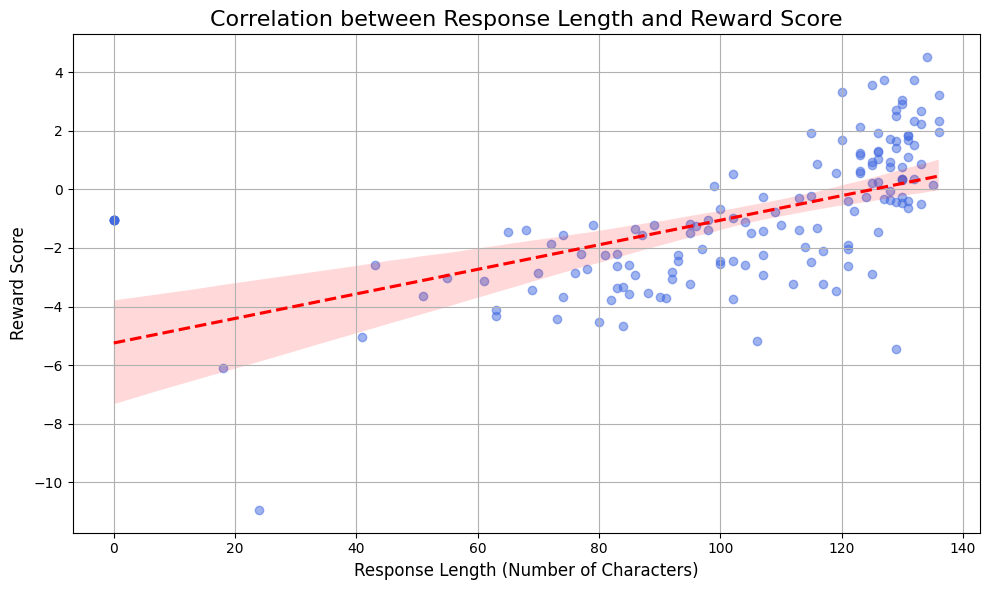

In [9]:
# --- 1. 피어슨 상관계수 계산 ---
print("📊 'score'와 'response_length' 간의 상관관계를 분석합니다...")

# .corr() 메소드를 사용하여 두 컬럼 간의 피어슨 상관계수를 계산합니다.
correlation = df['score'].corr(df['response_length'])

print("\n--- 분석 결과 ---")
print(f"점수(score)와 응답 길이(response_length) 간의 피어슨 상관계수: {correlation:.4f}")

# 상관계수 값에 대한 해석을 덧붙입니다.
if correlation > 0.5:
    print("해석: 강한 양의 상관관계가 있습니다. 모델이 긴 응답에 높은 점수를 주는 경향이 매우 강합니다. (길이 편향 의심)")
elif correlation > 0.2:
    print("해석: 약한 양의 상관관계가 있습니다. 모델이 긴 응답에 점수를 더 주는 경향이 있습니다.")
elif correlation < -0.5:
    print("해석: 강한 음의 상관관계가 있습니다. 모델이 짧은 응답에 높은 점수를 주는 경향이 매우 강합니다.")
elif correlation < -0.2:
    print("해석: 약한 음의 상관관계가 있습니다. 모델이 짧은 응답에 점수를 더 주는 경향이 있습니다.")
else:
    print("해석: 상관관계가 거의 없습니다. 모델이 응답 길이에 크게 영향을 받지 않는 것으로 보입니다.")


# --- 2. 산점도(Scatter Plot) 및 회귀선 시각화 ---

print("\n🎨 분석 결과를 시각화합니다...")

plt.figure(figsize=(10, 6))

# seaborn의 regplot을 사용하면 산점도와 회귀선을 한 번에 그릴 수 있습니다.
sns.regplot(
    data=df,
    x='response_length',
    y='score',
    scatter_kws={'alpha':0.5, 'color':'royalblue'}, # 점에 대한 스타일
    line_kws={'color':'red', 'linestyle':'--'}      # 회귀선에 대한 스타일
)

plt.title('Correlation between Response Length and Reward Score', fontsize=16)
plt.xlabel('Response Length (Number of Characters)', fontsize=12)
plt.ylabel('Reward Score', fontsize=12)
plt.grid(True)
plt.tight_layout()

# 생성된 그래프를 이미지 파일로 저장
plt.savefig("score_vs_length_correlation.png")
print("✅ 시각화 완료! 'score_vs_length_correlation.png' 파일이 저장되었습니다.")


## 분석

In [10]:
# --- 1. 'features' 컬럼을 2048개의 개별 컬럼으로 확장 ---

print("🔄 'features' 컬럼을 2048개의 개별 피처 컬럼으로 확장합니다...")

# .tolist()를 사용하면 리스트/배열로 구성된 컬럼을 효율적으로 데이터프레임으로 변환 가능
features_expanded_df = pd.DataFrame(df['features'].tolist(), index=df.index)

# 각 컬럼에 'feature_0', 'feature_1', ... 과 같이 이름을 붙여줍니다.
features_expanded_df.columns = [f'feature_{i}' for i in range(features_expanded_df.shape[1])]

# 기존 df에서 'features' 컬럼을 제외하고, 확장된 피처 df를 옆으로 붙입니다.
df_analyzable = pd.concat([df.drop('features', axis=1), features_expanded_df], axis=1)

print("✅ 피처 확장 완료! 분석용 데이터프레임 샘플:")
# 이제 각 feature가 개별 컬럼으로 들어간 것을 확인할 수 있습니다.
print(df_analyzable.head())

🔄 'features' 컬럼을 2048개의 개별 피처 컬럼으로 확장합니다...
✅ 피처 확장 완료! 분석용 데이터프레임 샘플:
                                            response     score  \
0  Okay, little one, imagine you are playing with...  3.726562   
1  A large language model is like a super smart r... -2.703125   
2  A large language model is a very smart compute... -1.034180   
3  Imagine you have a lot of books in your librar... -1.390625   
4  Imagine you have a computer that can read and ... -4.105469   

   response_length  feature_0  feature_1  feature_2  feature_3  feature_4  \
0              127   3.330078   5.863281   1.213867  -0.181885   1.919922   
1               78  -2.601562   3.904297   1.697266   1.065430   3.632812   
2               98  -3.195312   4.414062   2.523438  -0.380615   2.996094   
3               98  -2.697266   3.589844   2.605469   0.233154   1.737305   
4               63   0.196167   4.046875   2.330078   0.662598   3.117188   

   feature_5  feature_6  ...  feature_2038  feature_2039  feature_204

/nfs/home/ryan0507/anaconda3/envs/llama/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [11]:
# --- 2. 각 피처와 보상 점수 간의 상관관계 분석 ---

print("\n📊 각 피처와 보상 점수 간의 피어슨 상관관계를 계산합니다...")

# 'score' 컬럼과 'feature_*' 컬럼들 간의 상관관계만 계산
feature_columns = [col for col in df_analyzable if col.startswith('feature_')]
correlations = df_analyzable[feature_columns].corrwith(df_analyzable['score'])
correlations = correlations.sort_values(ascending=False)

print("\n--- 상관관계 분석 결과 ---")
print("\n[보상 점수와 가장 강한 양의 상관관계를 갖는 피처 Top 10]")
print(correlations.head(10))

print("\n[보상 점수와 가장 강한 음의 상관관계를 갖는 피처 Top 10]")
print(correlations.tail(10))


📊 각 피처와 보상 점수 간의 피어슨 상관관계를 계산합니다...

--- 상관관계 분석 결과 ---

[보상 점수와 가장 강한 양의 상관관계를 갖는 피처 Top 10]
feature_1412    0.777814
feature_720     0.767868
feature_558     0.760157
feature_1907    0.753174
feature_604     0.750570
feature_881     0.731431
feature_1415    0.726372
feature_188     0.721279
feature_293     0.718969
feature_2002    0.718439
dtype: float64

[보상 점수와 가장 강한 음의 상관관계를 갖는 피처 Top 10]
feature_461    -0.691798
feature_1079   -0.692096
feature_1475   -0.694703
feature_1081   -0.698609
feature_897    -0.703176
feature_725    -0.707481
feature_692    -0.712247
feature_1012   -0.727522
feature_549    -0.729348
feature_479    -0.743742
dtype: float64


/tmp/ipykernel_2570041/2969119911.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations.values, y=top_correlations.index, palette="vlag")



✅ 상관관계 시각화 완료! 'reward_feature_correlation.png' 파일이 저장되었습니다.


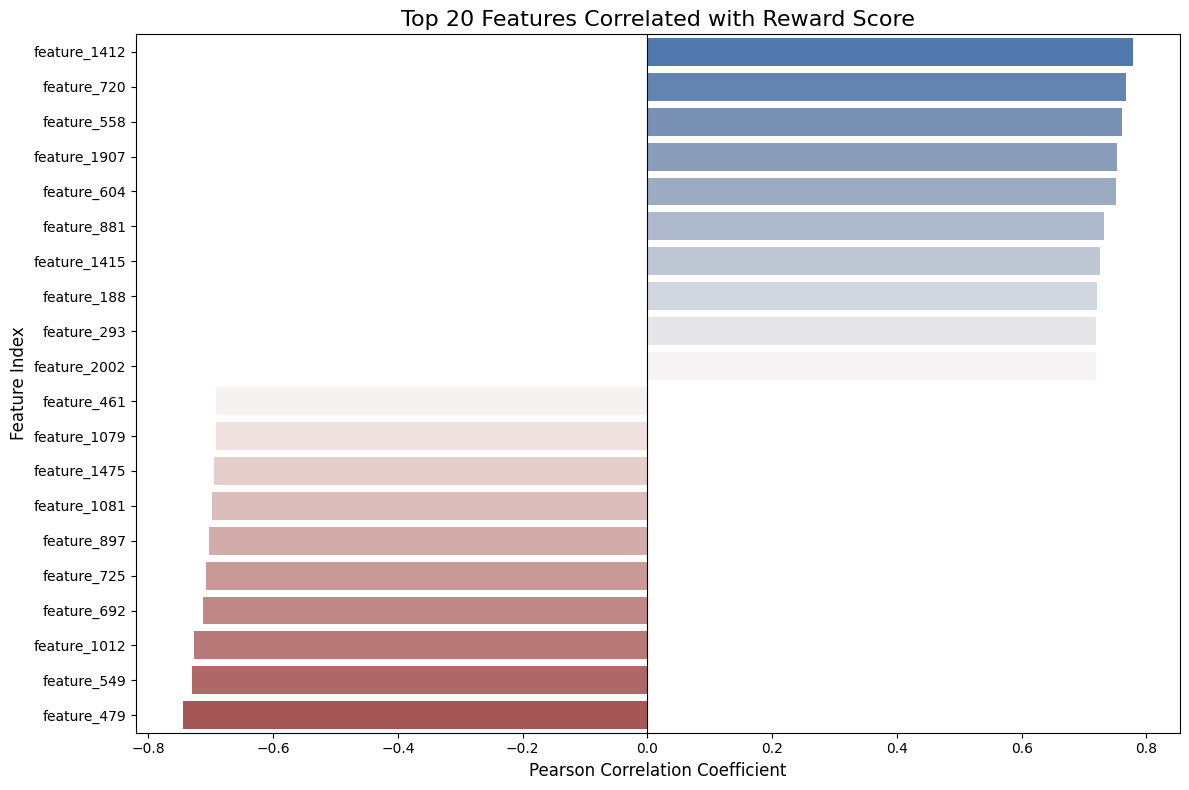

In [12]:
# --- 3. 상관관계 시각화 ---

top_n = 10
top_positive_corr = correlations.head(top_n)
top_negative_corr = correlations.tail(top_n)
top_correlations = pd.concat([top_positive_corr, top_negative_corr])

plt.figure(figsize=(12, 8))
sns.barplot(x=top_correlations.values, y=top_correlations.index, palette="vlag")
plt.title(f"Top {top_n*2} Features Correlated with Reward Score", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient", fontsize=12)
plt.ylabel("Feature Index", fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig("reward_feature_correlation.png")
print("\n✅ 상관관계 시각화 완료! 'reward_feature_correlation.png' 파일이 저장되었습니다.")


     전체 상관관계 분포 요약 통계
count    2048.000000
mean        0.016812
std         0.367648
min        -0.743742
25%        -0.290028
50%         0.023499
75%         0.329609
max         0.777814
dtype: float64

🎨 상관관계 분포를 시각화합니다...
✅ 분포 시각화 완료! 'correlation_distribution.png' 파일이 저장되었습니다.


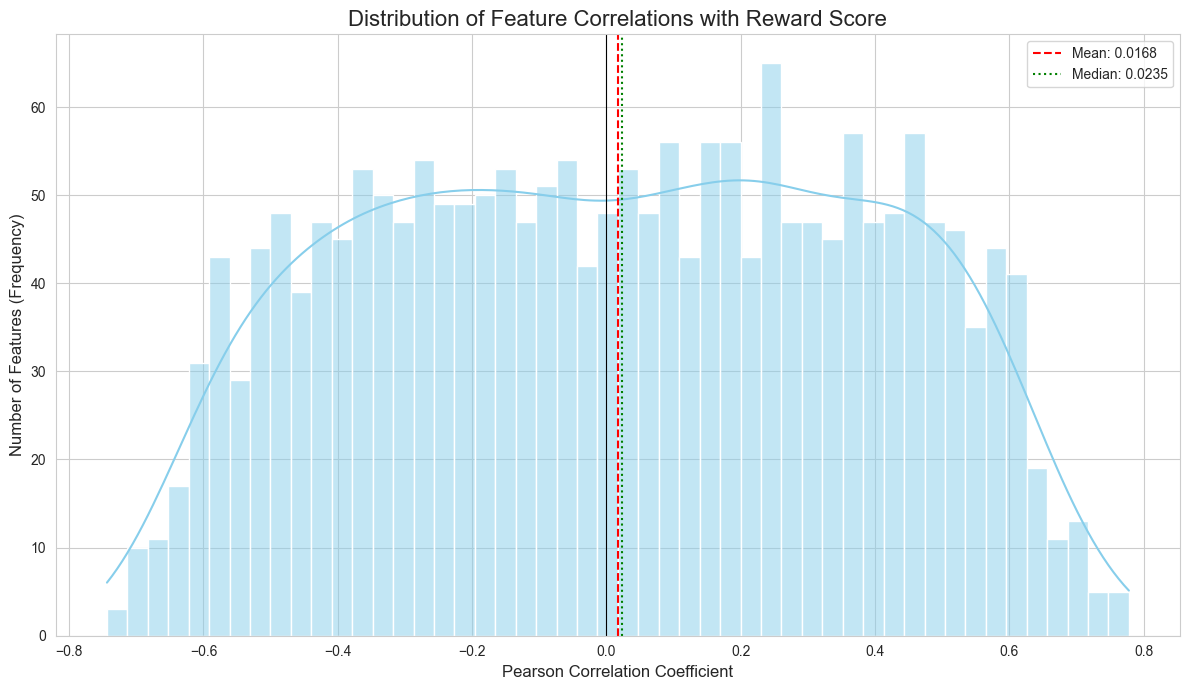

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 이전 단계에서 계산된 'correlations' 변수가 있다고 가정합니다.
# correlations = df_analyzable[feature_columns].corrwith(df_analyzable['score'])

# --- 1. 상관관계 분포에 대한 요약 통계 출력 ---

print("\n" + "="*40)
print("     전체 상관관계 분포 요약 통계")
print("="*40)
# .describe() 메소드는 개수, 평균, 표준편차, 최소값, 최대값, 사분위수를 보여줍니다.
print(correlations.describe())


# --- 2. 히스토그램 및 밀도 플롯 시각화 ---

print("\n🎨 상관관계 분포를 시각화합니다...")

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# histplot에 kde=True를 주면 히스토그램과 밀도 플롯을 함께 그립니다.
sns.histplot(correlations, kde=True, bins=50, color='skyblue')

# 분포의 평균과 중앙값을 수직선으로 표시하여 중심 경향을 파악합니다.
plt.axvline(correlations.mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {correlations.mean():.4f}')
plt.axvline(correlations.median(), color='green', linestyle=':', linewidth=1.5, label=f'Median: {correlations.median():.4f}')
plt.axvline(0, color='black', linestyle='-', linewidth=0.8) # 상관계수 0을 기준으로 표시

plt.title('Distribution of Feature Correlations with Reward Score', fontsize=16)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Number of Features (Frequency)', fontsize=12)
plt.legend()
plt.tight_layout()

# 생성된 그래프를 이미지 파일로 저장
plt.savefig("correlation_distribution.png")
print("✅ 분포 시각화 완료! 'correlation_distribution.png' 파일이 저장되었습니다.")

## feature 방향성 분석 (PCA)

In [14]:
# 피처와 점수를 numpy 배열로 변환
all_features = np.vstack(df['features'].values) # shape: (num_samples, feature_dim)
all_scores = df['score'].values.reshape(-1, 1)  # shape: (num_samples, 1)

In [26]:
# 피처 공간의 주성분 찾기
pca = PCA(n_components=20) # 상위 20개 주성분 확인
principal_components = pca.fit_transform(all_features)

# 각 주성분과 보상 점수 간의 상관관계 계산
pc_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(20)])
pc_df['score'] = all_scores

correlation_with_scores = pc_df.corr()['score'].abs().sort_values(ascending=False)
print("Correlation between PCs and Score:\n", correlation_with_scores[1:]) # score 자신 제외

# 보상 점수와 가장 상관관계가 높은 주성분(PC)을 '핵심 방향'으로 선택
most_correlated_pc_index = int(correlation_with_scores.index[1].replace('PC', '')) - 1
suspicious_direction = pca.components_[most_correlated_pc_index]

# 방향 벡터 정규화 (크기를 1로 만듦)
suspicious_direction = suspicious_direction / np.linalg.norm(suspicious_direction)

print(f"\n보상 점수와 가장 연관성이 높은 방향(PC{most_correlated_pc_index + 1})을 찾았습니다.")
print("Suspicious Direction Vector (shape):", suspicious_direction.shape)

Correlation between PCs and Score:
 PC1     0.716345
PC7     0.288993
PC5     0.239832
PC3     0.229011
PC9     0.207488
PC8     0.203513
PC13    0.199497
PC2     0.147799
PC19    0.146938
PC14    0.144956
PC10    0.134394
PC12    0.098157
PC18    0.079063
PC11    0.057946
PC4     0.056752
PC6     0.051692
PC17    0.049007
PC16    0.033203
PC20    0.030503
PC15    0.025900
Name: score, dtype: float64

보상 점수와 가장 연관성이 높은 방향(PC1)을 찾았습니다.
Suspicious Direction Vector (shape): (2048,)


## Mitigate Bias & Save

### feature 방향성 -> 점수 통일

In [27]:
# 이 함수는 점수와 피처를 모두 반환합니다.
def get_reward_score_and_features(model, tokenizer, prompt, response):
    """
    모델의 forward() 연산을 통해 점수와 피처를 모두 계산하는 함수.
    """
    text = prompt + tokenizer.eos_token + response
    # max_length를 충분히 길게 설정하여 잘리지 않도록 합니다.
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=2048).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        score = outputs.logits[0].item()
        # 마지막 토큰의 은닉 상태를 피처로 사용합니다.
        features = outputs.hidden_states[-1][:, -1, :].cpu().numpy().flatten()
        
    return score, features

In [28]:
print("🔄 1. 원본 모델을 사용하여 기준 점수 및 피처를 계산합니다...")

original_scores = []
all_features_list = []

for response in response_texts:
    score, features = get_reward_score_and_features(reward_model, tokenizer, analysis_prompt, response)
    original_scores.append(score)
    all_features_list.append(features)

# 분석을 위한 데이터프레임 생성
df = pd.DataFrame({
    'response': response_texts,
    'original_score': original_scores,
    'features': all_features_list
})
all_features = np.vstack(df['features'].values)

print("✅ 기준 점수 및 피처 계산 완료!")

🔄 1. 원본 모델을 사용하여 기준 점수 및 피처를 계산합니다...
✅ 기준 점수 및 피처 계산 완료!


In [29]:

# ====================================================================
# 3. '의심스러운 방향' 식별 (PCA)
# ====================================================================
print("\n🔄 2. PCA를 사용하여 보상 점수와 가장 연관성이 높은 '의심스러운 방향'을 식별합니다...")

pca = PCA(n_components=20)
principal_components = pca.fit_transform(all_features)

pc_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(20)])
pc_df['score'] = df['original_score']

correlation_with_scores = pc_df.corr()['score'].abs().sort_values(ascending=False)
most_correlated_pc_index = int(correlation_with_scores.index[1].replace('PC', '')) - 1
suspicious_direction = pca.components_[most_correlated_pc_index]
suspicious_direction = suspicious_direction / np.linalg.norm(suspicious_direction)

print(f"✅ PC{most_correlated_pc_index + 1} 방향을 '의심스러운 방향'으로 확정했습니다.")

print("Correlation between PCs and Score:\n", correlation_with_scores[1:])


🔄 2. PCA를 사용하여 보상 점수와 가장 연관성이 높은 '의심스러운 방향'을 식별합니다...
✅ PC1 방향을 '의심스러운 방향'으로 확정했습니다.
Correlation between PCs and Score:
 PC1     0.716345
PC7     0.288964
PC5     0.239884
PC3     0.229011
PC9     0.207118
PC8     0.203556
PC13    0.198641
PC2     0.147799
PC14    0.141934
PC10    0.134401
PC19    0.130944
PC12    0.099213
PC18    0.080444
PC20    0.075751
PC11    0.057795
PC4     0.056737
PC6     0.051512
PC17    0.050227
PC16    0.031490
PC15    0.026273
Name: score, dtype: float64


In [45]:

# ====================================================================
# 4. 가중치 수정 및 새 모델 생성
# ====================================================================
import copy

print("\n🔄 3. 원본 모델을 복사하여 새 모델을 만들고, 가중치를 수정합니다...")

# ✨ 요청사항 1: 원본 모델을 수정하지 않기 위해 deepcopy로 완전한 복사본을 생성합니다.
debiased_reward_model = copy.deepcopy(reward_model)

# 원본 가중치 벡터 가져오기 (어떤 모델에서 가져와도 동일합니다)
original_weights_tensor = reward_model.score.weight.detach().clone()
original_weights = original_weights_tensor.cpu().numpy().flatten()

# '의심스러운 방향'으로의 프로젝션 계산 및 제거
projection = np.dot(original_weights, suspicious_direction) * suspicious_direction
# 0.0~1.0 사이의 상수로 조정 (1.0은 완전 제거, 0.0은 아무 영향 없음)
# alpha = 0.5
alpha = 0.9
debiased_weights = original_weights - alpha * projection

# ✨ 수정된 가중치를 '새로운 모델'에만 적용합니다.
with torch.no_grad():
    debiased_weights_tensor = torch.tensor(debiased_weights, dtype=original_weights_tensor.dtype).unsqueeze(0)
    debiased_reward_model.score.weight.copy_(debiased_weights_tensor.to(debiased_reward_model.device))

print("✅ 'debiased_reward_model'에 수정된 가중치를 성공적으로 적용했습니다.")



🔄 3. 원본 모델을 복사하여 새 모델을 만들고, 가중치를 수정합니다...
✅ 'debiased_reward_model'에 수정된 가중치를 성공적으로 적용했습니다.


In [46]:
# ====================================================================
# 5. [방식 통일] 수정된 모델로 새 점수 계산 (기존 5번 수정)
# ====================================================================
print("\n🔄 4. 가중치가 수정된 'debiased_reward_model'을 사용하여 새로운 점수를 계산합니다...")

new_scores = []
# 이제 수정된 모델의 forward()를 통과하므로, 정확한 새 점수가 계산됩니다.
# 원본 reward_model은 그대로 유지됩니다.
for response in df['response']:
    score, _ = get_reward_score_and_features(debiased_reward_model, tokenizer, analysis_prompt, response)
    new_scores.append(score)

df['new_score'] = new_scores
df['response_length'] = df['response'].apply(len)

print("✅ 새로운 점수 계산 완료!")


🔄 4. 가중치가 수정된 'debiased_reward_model'을 사용하여 새로운 점수를 계산합니다...
✅ 새로운 점수 계산 완료!


In [47]:
# ====================================================================
# 6. 최종 결과 비교
# ====================================================================
print("\n" + "="*30)
print("       최종 상관관계 비교")
print("="*30)

original_corr = df['original_score'].corr(df['response_length'])
new_corr = df['new_score'].corr(df['response_length'])

print(f"Original Score vs Length Correlation: {original_corr:.6f}")
print(f"New Score vs Length Correlation     : {new_corr:.6f}")
print("="*30)



       최종 상관관계 비교
Original Score vs Length Correlation: 0.566095
New Score vs Length Correlation     : 0.491889


In [48]:
df

,response,original_score,features,new_score,response_length
0,"Okay, little one, imagine you are playing with...",3.726562,"[3.33, 5.863, 1.214, -0.1819, 1.92, 0.9116, 1....",3.066406,657
1,A large language model is like a super smart r...,-2.703125,"[-2.602, 3.904, 1.697, 1.065, 3.633, -1.722, 1...",-0.148560,397
2,A large language model is a very smart compute...,-1.034180,"[-3.195, 4.414, 2.523, -0.3806, 2.996, -3.754,...",1.466797,512
3,Imagine you have a lot of books in your librar...,-1.390625,"[-2.697, 3.59, 2.605, 0.2332, 1.737, -2.818, 1...",1.335938,507
4,Imagine you have a computer that can read and ...,-4.105469,"[0.1962, 4.047, 2.33, 0.6626, 3.117, -0.536, 1...",-1.917969,318
...,...,...,...,...,...
145,Imagine you're playing with blocks. You have a...,1.962891,"[2.756, 6.945, 0.9873, -1.214, 4.12, -1.303, 3...",1.349609,712
146,Imagine you're talking to a little robot who h...,-10.945312,"[1.888, 2.602, 0.01724, 0.9976, 3.771, -0.853,...",-9.359375,140
147,Imagine you have a big library with lots of bo...,-0.470947,"[0.761, 6.484, 2.512, 0.0835, 1.721, -2.729, 3...",-1.101562,675
148,Imagine you are talking to your friend.\n\nHey...,3.332031,"[-0.2917, 4.195, 0.902, 1.884, 4.93, 0.787, 0....",2.527344,625


In [49]:
# ====================================================================
# 7. 수정된 가중치 저장 (✨ 요청사항 2)
# ====================================================================
print("\n🔄 5. 수정된 'score' 레이어의 가중치를 파일로 저장합니다...")

# LoRA 어댑터와는 별개로, 우리가 수정한 'score' 레이어의 가중치 텐서만 따로 저장합니다.
# state_dict()를 저장하는 것이 더 안전하고 일반적인 방법입니다.
debiased_weights_save_path = "./debiased_score_weights.pt" 
torch.save(debiased_reward_model.score.state_dict(), debiased_weights_save_path)

print(f"✅ 수정된 score 레이어의 가중치가 '{debiased_weights_save_path}'에 저장되었습니다.")


🔄 5. 수정된 'score' 레이어의 가중치를 파일로 저장합니다...
✅ 수정된 score 레이어의 가중치가 './debiased_score_weights.pt'에 저장되었습니다.


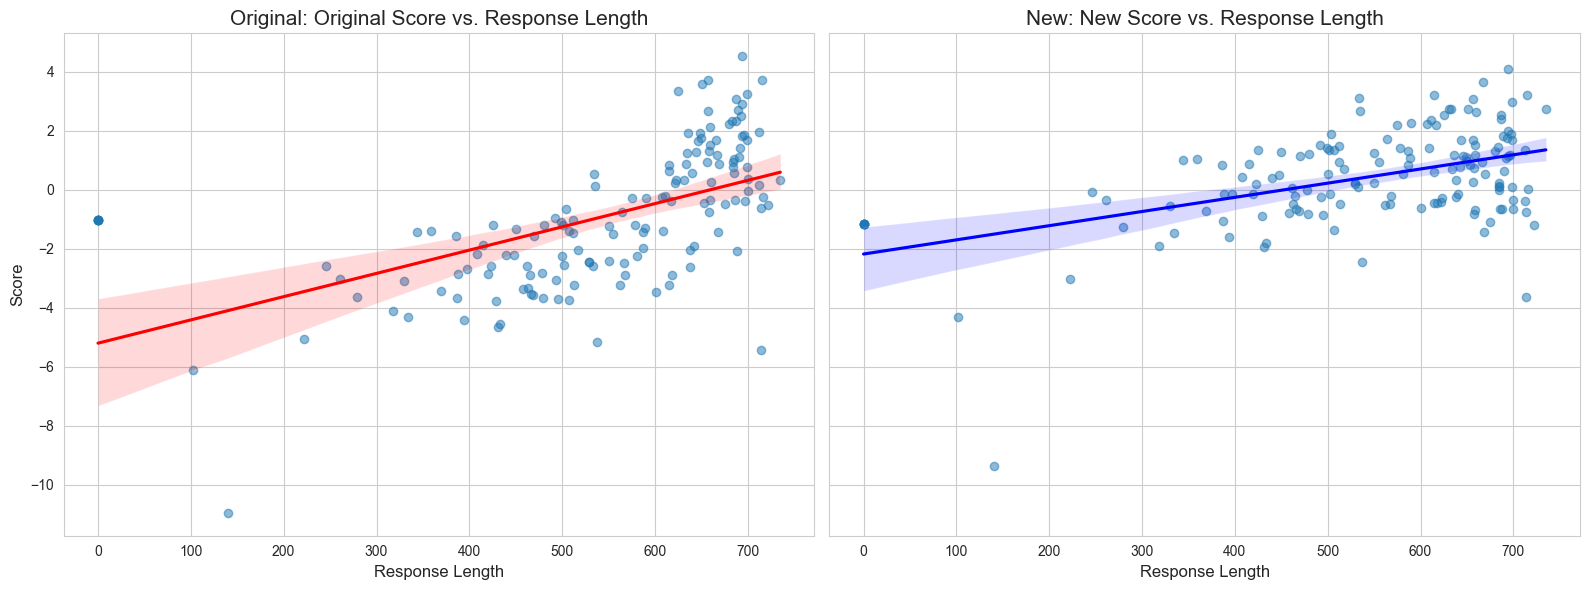

In [50]:
# 1x2 그리드로 두 개의 그래프를 나란히 배치합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# 그래프 1: 원본 점수 vs 길이
sns.regplot(ax=axes[0], data=df, x='response_length', y='original_score', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0].set_title('Original: Original Score vs. Response Length', fontsize=15)
axes[0].set_xlabel('Response Length', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].grid(True)

# 그래프 2: 새로운 점수 vs 길이
sns.regplot(ax=axes[1], data=df, x='response_length', y='new_score', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
axes[1].set_title('New: New Score vs. Response Length', fontsize=15)
axes[1].set_xlabel('Response Length', fontsize=12)
axes[1].set_ylabel('') # y축 라벨은 왼쪽 그래프와 공유하므로 생략
axes[1].grid(True)

# fig.suptitle('응답 길이와 점수 간의 관계 변화 비교', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

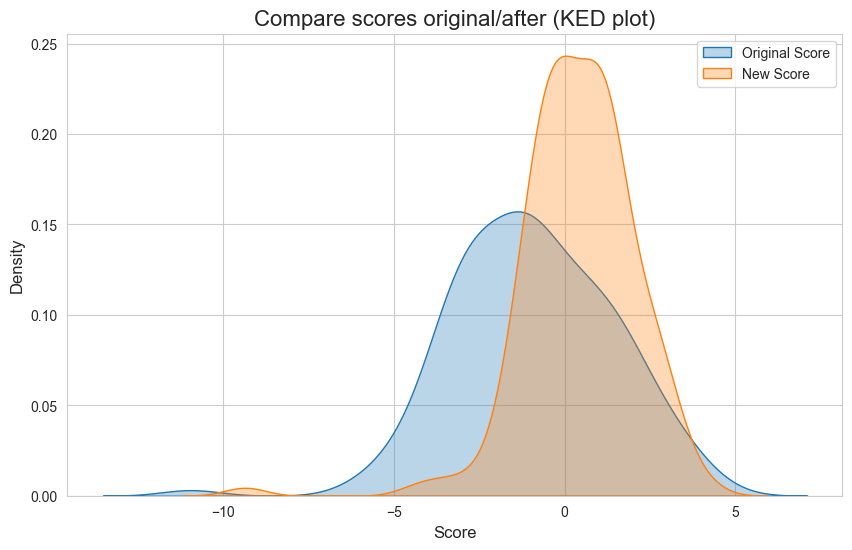

In [51]:
plt.figure(figsize=(10, 6))

sns.kdeplot(data=df, x='original_score', label='Original Score', fill=True, alpha=0.3)
sns.kdeplot(data=df, x='new_score', label='New Score', fill=True, alpha=0.3)

# plt.title('수정 전후 점수 분포 비교 (KDE Plot)', fontsize=16)
plt.title('Compare scores original/after (KED plot)', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

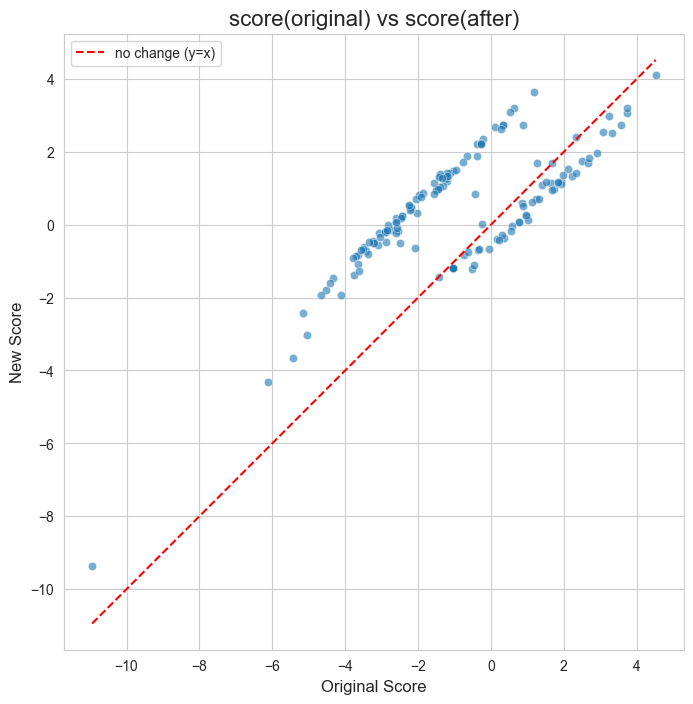

In [52]:
plt.figure(figsize=(8, 8))

sns.scatterplot(data=df, x='original_score', y='new_score', alpha=0.6)

# y=x 대각선 추가 (점수 변화가 없는 기준선)
max_val = max(df['original_score'].max(), df['new_score'].max())
min_val = min(df['original_score'].min(), df['new_score'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='no change (y=x)')
# plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='점수 변화 없음 (y=x)')

plt.title('score(original) vs score(after)', fontsize=16)
plt.xlabel('Original Score', fontsize=12)
plt.ylabel('New Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal') # x축과 y축의 스케일을 동일하게 설정
plt.show()